In [9]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from v1dd_public import ARTIFACT_DIR
import seaborn as sns
from pathlib import Path

In [10]:
mouse_colors = {'slc2': "#66CCEE", 'slc4': "#228833", 'slc5': '#CCBB44', 'teto1': '#EE6677'}
mice = ['slc2', 'slc4', 'slc5', 'teto1']
mouse_ids = ["M409828", "M416296", "M427836", "M438833"]
z_groups_high_to_low = [[575, 600, 625], [650, 675, 700, 725], [500, 525, 550], [482, 498, 514], [434, 450, 466], \
    [386, 402, 418], [338, 354, 370], [290, 306, 322], [242, 258, 274], [194, 210, 226], [146, 162, 178], [98, 114, 130], [50, 66, 82]]
z_groups_low_to_high = [[50, 66, 82], [98, 114, 130], [146, 162, 178], [194, 210, 226], [242, 258, 274], [290, 306, 322], [338, 354, 370], \
    [386, 402, 418], [434, 450, 466], [482, 498, 514], [500, 525, 550], [575, 600, 625], [650, 675, 700, 725]]

z_groups_high_to_low = [[50], [66], [82], [98], [114], [130], [146], [162], [178], [194], [210], [226], \
    [242], [258], [274], [290], [306], [322], [338], [354], [370], [386], [402], [418], \
    [434], [450], [466], [482], [498], [514], [500], [525], [550], [575], [600], [625], \
    [650], [675], [700], [725]]
z_groups_low_to_high = [[50], [66], [82], [98], [114], [130], [146], [162], [178], [194], [210], [226], \
    [242], [258], [274], [290], [306], [322], [338], [354], [370], [386], [402], [418], \
    [434], [450], [466], [482], [498], [514], [500], [525], [550], [575], [600], [625], \
    [650, 675, 700, 725]]

In [11]:
stim_types = [
    "drifting_gratings_full", 
    "drifting_gratings_windowed", 
    "natural_images_12", 
    "natural_images"
    ]
decode_dims = {
    "drifting_gratings_full": ["direction", "spatial"],
    "drifting_gratings_windowed": ["direction", "spatial"],
    "natural_images_12": ["image_index"],
    "natural_images": ["image_index"]
               }
repetitions = 1000

chance = {
    "drifting_gratings_full_direction": 1/12, 
    "drifting_gratings_full_spatial": 1/2, 
    "drifting_gratings_full_direction_spatial": 1/24, 
    "drifting_gratings_windowed_direction": 1/12, 
    "drifting_gratings_windowed_spatial": 1/2, 
    "drifting_gratings_windowed_direction_spatial": 1/24, 
    "natural_images_12_image_index": 1/12,
    "natural_images_image_index": 1/118}

depth_mapping = {
    66: [50, 66, 82],
    114: [98, 114, 130], 
    162: [146, 162, 178],
    210: [194, 210, 226],
    258: [242, 258, 274],
    306: [290, 306, 322],
    354: [338, 354, 370],
    402: [386, 402, 418],
    450: [434, 450, 466],
    498: [482, 498, 514]
}

depths = [66,
    114, 
    162,
    210,
    258,
    306,
    354,
    402,
    450,
    498]

In [12]:
def depth_volume_mapping(a, b):
    depth_values = {
        1: {1: 66, 4: 114},
        2: {1: 162, 4: 210},
        3: {1: 258, 4: 306},
        4: {1: 354, 4: 402},
        5: {1: 450, 4: 498},
    }

    return depth_values[a][b[1]]


In [13]:
tag = "20240731"
all_results_df = pd.DataFrame()
for stim_type in stim_types:
    stim_decode_dims = decode_dims[stim_type]
    for decode_dim in stim_decode_dims:

        path_name = os.path.join(ARTIFACT_DIR, f'decoding_analyses/{tag}_{stim_type}_{decode_dim}')
        results_df = pd.DataFrame()
        for filename in os.listdir(path_name):
            f = os.path.join(path_name, filename)
            results_df = pd.concat([results_df, pd.read_pickle(f)])
        
        results_df['stim_type'] = stim_type
        results_df['decode_dim'] = decode_dim

        all_results_df = pd.concat([all_results_df, results_df], axis=0)

all_results_df['depth'] = all_results_df.apply(lambda x: depth_volume_mapping(a = x['volume_id'], b = x['planes']), axis=1)

(9.5, -0.5)


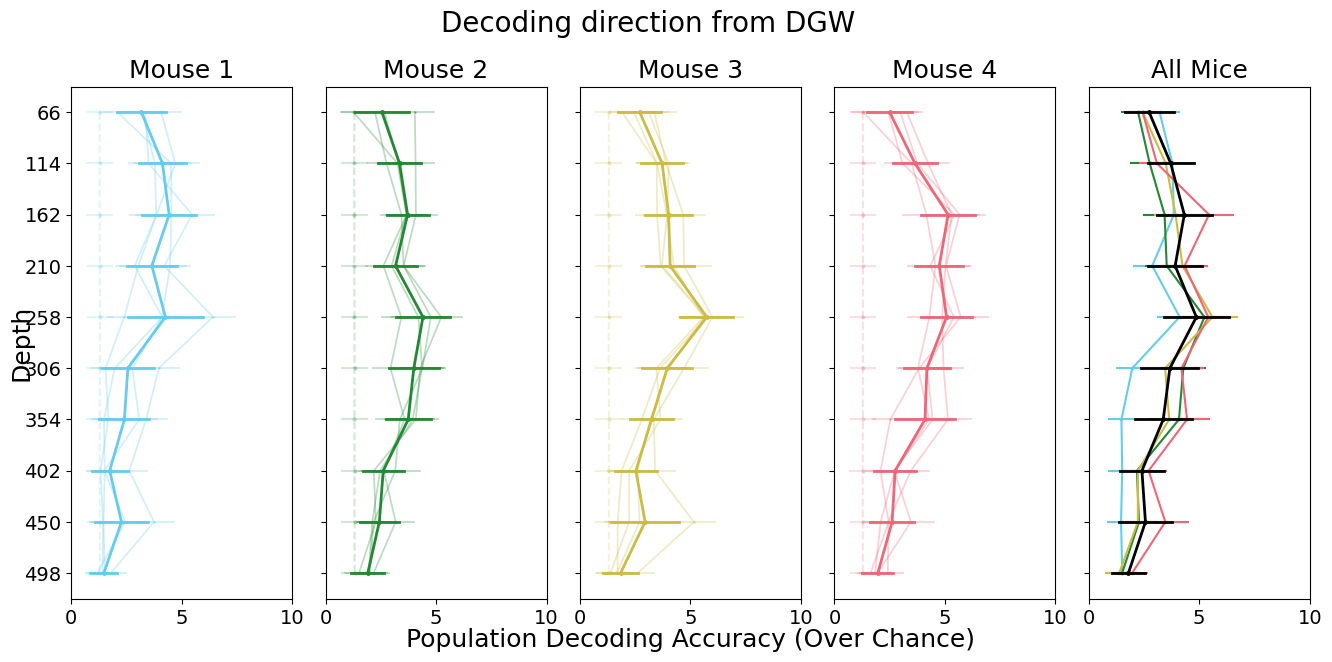

In [14]:
fig, axs = plt.subplots(1,5,sharex=True, sharey=True, figsize=(14, 7))
jitter_amount = 0.15
n_z_groups = 10
num_elements = len(mice)
jitter_step = jitter_amount * 2 / (num_elements - 1)
jitter_values = np.linspace(-jitter_amount, jitter_amount, num_elements)
fixed_jitters = np.tile(jitter_values, (n_z_groups, 1))

sub_results_df = all_results_df[
    (all_results_df['decode_dim'] == "direction") &
    (all_results_df['stim_type'] == "drifting_gratings_windowed")
    ]

sub_test_results_df = sub_results_df.explode('test_accuracies')
sub_shuf_results_df = sub_results_df.explode('shuf_test_accuracies')
sub_test_results_df['test_accuracies'] = sub_test_results_df['test_accuracies'] / (1/12)
sub_shuf_results_df['shuf_test_accuracies'] = sub_shuf_results_df['shuf_test_accuracies'] / (1/12)


for idx, mouse in enumerate(sub_results_df.mouse_id.unique()):
    temp_df = sub_test_results_df[(sub_test_results_df['mouse_id'] == mouse)]

    sns.pointplot(
        data=temp_df,
        y='depth',
        x="test_accuracies",
        orient='h',
        color=mouse_colors[mice[idx]],
        errorbar="sd",
        linewidth=2,
        markersize=2,
        ax=axs[idx],
    )

    temp_df = sub_shuf_results_df[(sub_shuf_results_df['mouse_id'] == mouse)]
    sns.pointplot(
        data=temp_df,
        y='depth',
        x="shuf_test_accuracies",
        orient='h',
        color=mouse_colors[mice[idx]],
        errorbar="sd",
        linewidth=1.5,
        markersize=2,
        alpha=0.2,
        linestyle="--",
        ax=axs[idx]
    )

    axs[idx].tick_params(axis='both', which='major', labelsize=14)
    axs[idx].set_xlim(0, 8)
    axs[idx].set_xlabel('')
    axs[idx].set_ylabel('')
    axs[idx].set_title(f'Mouse {idx+1}', fontsize=18)

for idx, mouse in enumerate(sub_test_results_df.mouse_id.unique()):
    for column in sub_test_results_df.column_id.unique():
        temp_df = sub_test_results_df[(sub_test_results_df['mouse_id'] == mouse) & (sub_test_results_df['column_id'] == column)]

        sns.pointplot(
            data=temp_df,
            y='depth',
            x="test_accuracies",
            orient='h',
            color=mouse_colors[mice[idx]],
            errorbar="sd",
            linewidth=1.25,
            markersize=1.,
            alpha=.3,
            ax=axs[idx]
        )
        axs[idx].set_xlabel('')
        axs[idx].set_ylabel('')


for idx, mouse in enumerate(sub_test_results_df.mouse_id.unique()):
    temp_df = sub_test_results_df[(sub_test_results_df['mouse_id'] == mouse) & (sub_test_results_df['column_id'] == column)]

    sns.pointplot(
        data=temp_df,
        y='depth',
        x="test_accuracies",
        orient='h',
        color=mouse_colors[mice[idx]],
        errorbar="sd",
        linewidth=1.5,
        markersize=1.5,
        alpha=1,
        ax=axs[4]
    )

sns.pointplot(
        data=sub_test_results_df,
        y='depth',
        x="test_accuracies",
        orient='h',
        color='black',
        errorbar="sd",
        linewidth=2,
        markersize=2,
        alpha=1,
        ax=axs[4]
    )

print(plt.ylim())

# plt.ylim(50, 514)
axs[4].tick_params(axis='both', which='major', labelsize=14)
axs[4].set_xlim(0, 10)
axs[4].set_xlabel('')
axs[4].set_ylabel('')
axs[4].set_title('All Mice', fontsize=18)

plt.suptitle('Decoding direction from DGW', fontsize=20)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)

plt.xlabel('Population Decoding Accuracy (Over Chance)', fontsize=18)
plt.ylabel('Depth', fontsize=18)

plt.tight_layout()

# plt.savefig(os.path.join(figures_dir, '5A_DGW_decoding.svg'), format='svg', bbox_inches='tight', dpi=300)

NameError: name 'figures_dir' is not defined

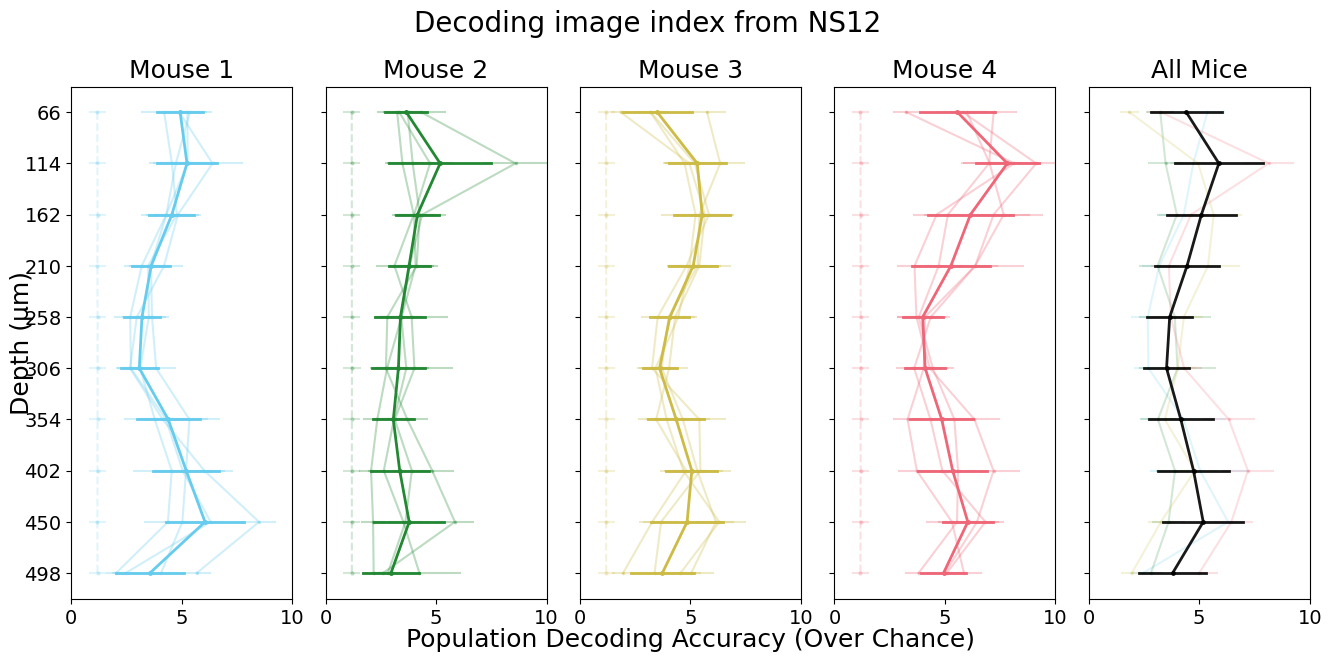

In [15]:
fig, axs = plt.subplots(1,5,sharex=True, sharey=True, figsize=(14, 7))
jitter_amount = 0.15
n_z_groups = 10
num_elements = len(mice)
jitter_step = jitter_amount * 2 / (num_elements - 1)
jitter_values = np.linspace(-jitter_amount, jitter_amount, num_elements)
fixed_jitters = np.tile(jitter_values, (n_z_groups, 1))

sub_results_df = all_results_df[
    (all_results_df['decode_dim'] == "image_index") &
    (all_results_df['stim_type'] == "natural_images_12")
    ]

sub_test_results_df = sub_results_df.explode('test_accuracies')
sub_shuf_results_df = sub_results_df.explode('shuf_test_accuracies')
sub_test_results_df['test_accuracies'] = sub_test_results_df['test_accuracies'] / (1/12)
sub_shuf_results_df['shuf_test_accuracies'] = sub_shuf_results_df['shuf_test_accuracies'] / (1/12)

for idx, mouse in enumerate(sub_results_df.mouse_id.unique()):
    temp_df = sub_test_results_df[(sub_test_results_df['mouse_id'] == mouse)]

    sns.pointplot(
        data=temp_df,
        y='depth',
        x="test_accuracies",
        orient='h',
        color=mouse_colors[mice[idx]],
        errorbar="sd",
        linewidth=2,
        markersize=2,
        ax=axs[idx],
    )

    temp_df = sub_shuf_results_df[(sub_shuf_results_df['mouse_id'] == mouse)]
    sns.pointplot(
        data=temp_df,
        y='depth',
        x="shuf_test_accuracies",
        orient='h',
        color=mouse_colors[mice[idx]],
        errorbar="sd",
        linewidth=1.5,
        markersize=2,
        alpha=0.2,
        linestyle="--",
        ax=axs[idx]
    )

    axs[idx].set_xlim(0, 8)
    axs[idx].tick_params(axis='both', which='major', labelsize=14)
    axs[idx].set_xlabel('')
    axs[idx].set_ylabel('')

    axs[idx].set_title(f'Mouse {idx+1}', fontsize=18)

for idx, mouse in enumerate(sub_test_results_df.mouse_id.unique()):
    for column in sub_test_results_df.column_id.unique():
        temp_df = sub_test_results_df[(sub_test_results_df['mouse_id'] == mouse) & (sub_test_results_df['column_id'] == column)]

        sns.pointplot(
            data=temp_df,
            y='depth',
            x="test_accuracies",
            orient='h',
            color=mouse_colors[mice[idx]],
            errorbar="sd",
            linewidth=1.5,
            markersize=1.5,
            alpha=.3,
            ax=axs[idx]
        )
        axs[idx].set_xlabel('')
        axs[idx].set_ylabel('')


for idx, mouse in enumerate(sub_test_results_df.mouse_id.unique()):
    temp_df = sub_test_results_df[(sub_test_results_df['mouse_id'] == mouse) & (sub_test_results_df['column_id'] == column)]

    sns.pointplot(
        data=temp_df,
        y='depth',
        x="test_accuracies",
        orient='h',
        color=mouse_colors[mice[idx]],
        errorbar="sd",
        linewidth=1.5,
        markersize=1.5,
        alpha=.2,
        ax=axs[4]
    )

sns.pointplot(
        data=sub_test_results_df,
        y='depth',
        x="test_accuracies",
        orient='h',
        color='black',
        errorbar="sd",
        linewidth=2,
        markersize=2,
        alpha=0.9,
        ax=axs[4]
    )

axs[4].set_xlim(0, 10)
axs[4].tick_params(axis='both', which='major', labelsize=14)
axs[4].set_xlabel('')
axs[4].set_ylabel('')
axs[4].set_title('All Mice', fontsize=18)

plt.suptitle('Decoding image index from NS12', fontsize=20)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)

plt.xlabel('Population Decoding Accuracy (Over Chance)', fontsize=18)
plt.ylabel("Depth (µm)", fontsize=18)

plt.tight_layout()

plt.savefig(os.path.join(figures_dir, '5B_NS12_decoding.svg'), format='svg', bbox_inches='tight', dpi=300)

In [ ]:
stim_types = [
    "drifting_gratings_full", 
    "drifting_gratings_windowed", 
    "natural_images_12", 
    "natural_images"
    ]
decode_dims = {
    "drifting_gratings_full": ["direction"],
    "drifting_gratings_windowed": ["direction"],
    "natural_images_12": ["image_index"],
    "natural_images": ["image_index"]
               }

In [ ]:
n_bootstrap = 1000
n_depths = len(depths)
mouse_ids_mod = [409828, 416296, 427836, 438833]
n_mice = len(mouse_ids_mod)
column_ids = [2, 3, 4, 5]
n_columns = len(column_ids)
bootstrapped_data = np.zeros((n_bootstrap, n_depths, n_mice, n_columns))

stim_type = 'drifting_gratings_windowed'
decode_dim = 'direction'

for m, mouse_id in enumerate(mouse_ids_mod):
    for c, column_id in enumerate(column_ids):
        for z, depth in enumerate(depths):
                test_accuracies_mean = all_results_df[
                    (all_results_df['mouse_id'] == mouse_id) & 
                    (all_results_df['depth'] == depth) &
                    (all_results_df['stim_type'] == stim_type) &
                    (all_results_df['decode_dim'] == decode_dim) & 
                    (all_results_df['column_id'] == column_id)
                    ].test_accuracies_mean.values
                    
                if len(test_accuracies_mean) > 0:
                    bootstrapped_data[:, z, m, c] = test_accuracies_mean
                else:
                    print(f"Missing data for {stim_type}, {decode_dim}, {mouse_id}, {column_id}, {depth}")
                    bootstrapped_data[:, z, m, c] = np.nan
                    continue

bootstrapped_data = bootstrapped_data / (1/12)

In [ ]:
n_bootstrap = 1000
n_depths = len(depths)
mouse_ids_mod = [409828, 416296, 427836, 438833]
n_mice = len(mouse_ids_mod)
column_ids = [2, 3, 4, 5]
n_columns = len(column_ids)
shuf_bootstrapped_data = np.zeros((n_bootstrap, n_depths, n_mice, n_columns))

stim_type = 'drifting_gratings_windowed'
decode_dim = 'direction'

for m, mouse_id in enumerate(mouse_ids_mod):
    for c, column_id in enumerate(column_ids):
        for z, depth in enumerate(depths):
                shuf_test_accuracies_mean = all_results_df[
                    (all_results_df['mouse_id'] == mouse_id) & 
                    (all_results_df['depth'] == depth) &
                    (all_results_df['stim_type'] == stim_type) &
                    (all_results_df['decode_dim'] == decode_dim) & 
                    (all_results_df['column_id'] == column_id)
                    ].shuf_test_accuracies_mean.values
                    
                if len(shuf_test_accuracies_mean) > 0:
                    shuf_bootstrapped_data[:, z, m, c] = shuf_test_accuracies_mean
                else:
                    print(f"Missing data for {stim_type}, {decode_dim}, {mouse_id}, {column_id}, {depth}")
                    shuf_bootstrapped_data[:, z, m, c] = np.nan
                    continue

shuf_bootstrapped_data = shuf_bootstrapped_data / (1/12)

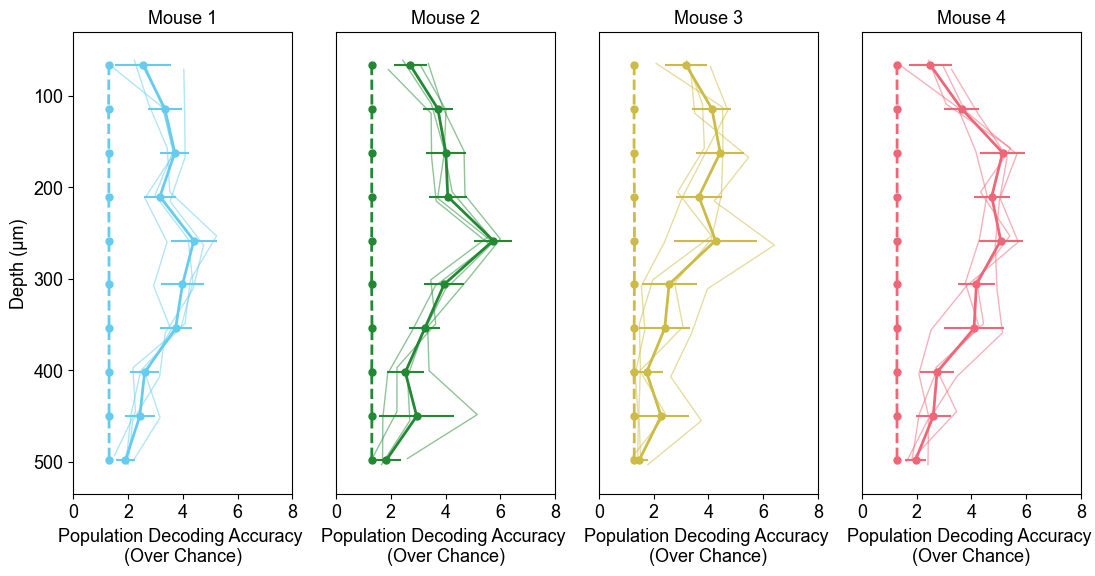

In [ ]:
jitter_amount = 5
num_elements = len(column_ids)
jitter_step = jitter_amount * 2 / (num_elements - 1)
jitter_values = np.linspace(-jitter_amount, jitter_amount, num_elements)
fixed_jitters = np.tile(jitter_values, (n_depths, 1))
titles = [
    'Mouse 1',
    'Mouse 2',
    'Mouse 3',
    'Mouse 4',
    'All Mice'
]

fig = plt.figure(figsize=(13, 6))

for m, mouse_id in enumerate(mice):
    
    ax = plt.subplot(1, n_mice, m + 1)
    mouse_color = mouse_colors[mice[m]]

    for c, column_id in enumerate(column_ids):
        means = []
        std_errors = []
        for z in range(n_depths):
            bootstrapped_values = bootstrapped_data[:, z, m, c]
            mean = np.mean(bootstrapped_values)
            std = np.std(bootstrapped_values)
            
            means.append(mean)
            std_errors.append(std)

        jitter = fixed_jitters[:, 3-c]
        y_positions = np.array([int(np.mean(x)) for x in z_groups_low_to_high[:-3]]) + jitter

        # plt.errorbar(means, y_positions, xerr=std_errors, fmt='o', color=mouse_color, ecolor=mouse_color, capsize=0, markersize=2, linewidth=1)
        plt.plot(means, y_positions, color=mouse_color, linewidth=1, alpha=0.5)
    
    means = []
    std_errors = []
    for z in range(n_depths):
        bootstrapped_values = bootstrapped_data[:, z, m, :]
        mean = np.mean(bootstrapped_values)
        std = np.std(bootstrapped_values)
        
        means.append(mean)
        std_errors.append(std)

    y_positions = np.array([int(np.mean(x)) for x in z_groups_low_to_high[:-3]])
    
    plt.errorbar(means, y_positions, xerr=std_errors, fmt='o', color=mouse_color, ecolor=mouse_color, capsize=0, markersize=5)
    plt.plot(means, y_positions, color=mouse_color, linewidth=2)

    means = []
    std_errors = []
    for z in range(n_depths):
        bootstrapped_values = shuf_bootstrapped_data[:, z, m, :]
        mean = np.mean(bootstrapped_values)
        std = np.std(bootstrapped_values)
        
        means.append(mean)
        std_errors.append(std)
    
    y_positions = np.array([int(np.mean(x)) for x in z_groups_low_to_high[:-3]])
    plt.errorbar(means, y_positions, xerr=std_errors, fmt='o', color=mouse_color, ecolor=mouse_color, capsize=0, markersize=5, linewidth=0.01)
    plt.plot(means, y_positions, color=mouse_color, linewidth=2, linestyle='--')

    plt.xlabel('Population Decoding Accuracy \n(Over Chance)', fontsize=fontsize)
    plt.title(titles[m], fontsize=fontsize)

    if m == 0:
        plt.yticks(fontsize=fontsize)
        plt.ylabel("Depth (µm)", fontsize=fontsize)
    else:
        plt.yticks([])

    plt.xticks(fontsize=fontsize)
    plt.ylim(30, 535)
    plt.xlim(0, 8)
    plt.gca().invert_yaxis()
# plt.show()
plt.savefig(os.path.join(figures_dir, '5A_decoding_accuracy_DGW.svg'), format='svg', bbox_inches='tight', dpi=300)

In [ ]:
n_bootstrap = 1000
n_depths = len(depths)
mouse_ids_mod = [409828, 416296, 427836, 438833]
n_mice = len(mouse_ids_mod)
column_ids = [2, 3, 4, 5]
n_columns = len(column_ids)
bootstrapped_data = np.zeros((n_bootstrap, n_depths, n_mice, n_columns))

stim_type = 'natural_images_12'
decode_dim = 'image_index'

for m, mouse_id in enumerate(mouse_ids_mod):
    for c, column_id in enumerate(column_ids):
        for z, depth in enumerate(depths):
                test_accuracies_mean = all_results_df[
                    (all_results_df['mouse_id'] == mouse_id) & 
                    (all_results_df['depth'] == depth) &
                    (all_results_df['stim_type'] == stim_type) &
                    (all_results_df['decode_dim'] == decode_dim) & 
                    (all_results_df['column_id'] == column_id)
                    ].test_accuracies_mean.values
                    
                if len(test_accuracies_mean) > 0:
                    bootstrapped_data[:, z, m, c] = test_accuracies_mean
                else:
                    print(f"Missing data for {stim_type}, {decode_dim}, {mouse_id}, {column_id}, {depth}")
                    bootstrapped_data[:, z, m, c] = np.nan
                    continue

bootstrapped_data = bootstrapped_data / (1/12)

In [ ]:
n_bootstrap = 1000
n_depths = len(depths)
mouse_ids_mod = [409828, 416296, 427836, 438833]
n_mice = len(mouse_ids_mod)
column_ids = [2, 3, 4, 5]
n_columns = len(column_ids)
shuf_bootstrapped_data = np.zeros((n_bootstrap, n_depths, n_mice, n_columns))

stim_type = 'natural_images_12'
decode_dim = 'image_index'

for m, mouse_id in enumerate(mouse_ids_mod):
    for c, column_id in enumerate(column_ids):
        for z, depth in enumerate(depths):
                shuf_test_accuracies_mean = all_results_df[
                    (all_results_df['mouse_id'] == mouse_id) & 
                    (all_results_df['depth'] == depth) &
                    (all_results_df['stim_type'] == stim_type) &
                    (all_results_df['decode_dim'] == decode_dim) & 
                    (all_results_df['column_id'] == column_id)
                    ].shuf_test_accuracies_mean.values
                    
                if len(shuf_test_accuracies_mean) > 0:
                    shuf_bootstrapped_data[:, z, m, c] = shuf_test_accuracies_mean
                else:
                    print(f"Missing data for {stim_type}, {decode_dim}, {mouse_id}, {column_id}, {depth}")
                    shuf_bootstrapped_data[:, z, m, c] = np.nan
                    continue

shuf_bootstrapped_data = shuf_bootstrapped_data / (1/12)

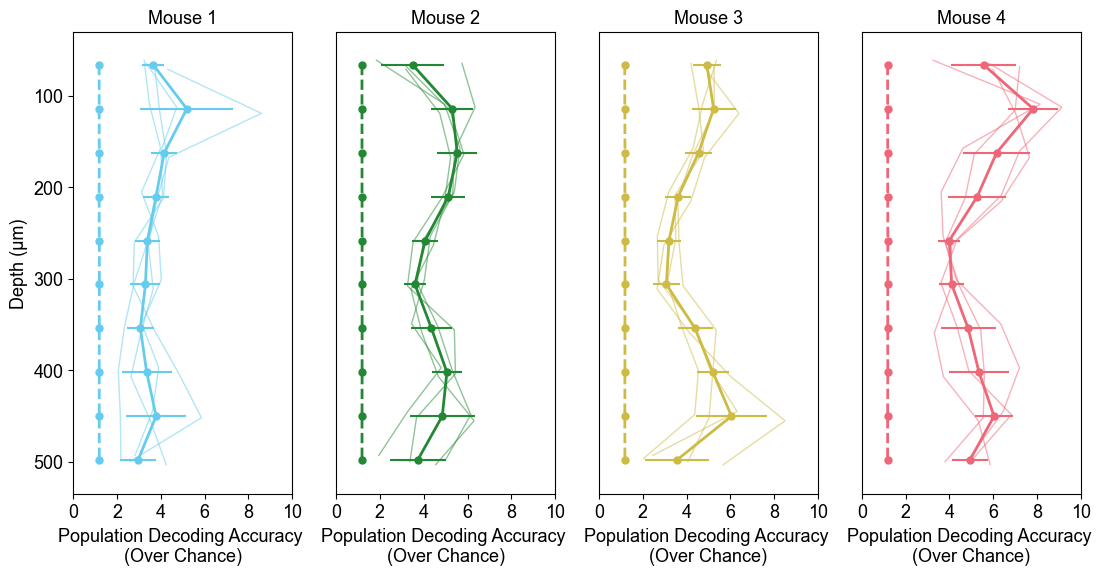

In [ ]:
jitter_amount = 5
num_elements = len(column_ids)
jitter_step = jitter_amount * 2 / (num_elements - 1)
jitter_values = np.linspace(-jitter_amount, jitter_amount, num_elements)
fixed_jitters = np.tile(jitter_values, (n_depths, 1))
titles = [
    'Mouse 1',
    'Mouse 2',
    'Mouse 3',
    'Mouse 4',
    'All Mice'
]

fig = plt.figure(figsize=(13, 6))

for m, mouse_id in enumerate(mice):
    
    ax = plt.subplot(1, n_mice, m + 1)
    mouse_color = mouse_colors[mice[m]]

    for c, column_id in enumerate(column_ids):
        means = []
        std_errors = []
        for z in range(n_depths):
            bootstrapped_values = bootstrapped_data[:, z, m, c]
            mean = np.mean(bootstrapped_values)
            std = np.std(bootstrapped_values)
            
            means.append(mean)
            std_errors.append(std)

        jitter = fixed_jitters[:, 3-c]
        y_positions = np.array([int(np.mean(x)) for x in z_groups_low_to_high[:-3]]) + jitter

        # plt.errorbar(means, y_positions, xerr=std_errors, fmt='o', color=mouse_color, ecolor=mouse_color, capsize=0, markersize=2, linewidth=1)
        plt.plot(means, y_positions, color=mouse_color, linewidth=1, alpha=0.5)
    
    means = []
    std_errors = []
    for z in range(n_depths):
        bootstrapped_values = bootstrapped_data[:, z, m, :]
        mean = np.mean(bootstrapped_values)
        std = np.std(bootstrapped_values)
        
        means.append(mean)
        std_errors.append(std)

    y_positions = np.array([int(np.mean(x)) for x in z_groups_low_to_high[:-3]])
    
    plt.errorbar(means, y_positions, xerr=std_errors, fmt='o', color=mouse_color, ecolor=mouse_color, capsize=0, markersize=5)
    plt.plot(means, y_positions, color=mouse_color, linewidth=2)

    means = []
    std_errors = []
    for z in range(n_depths):
        bootstrapped_values = shuf_bootstrapped_data[:, z, m, :]
        mean = np.mean(bootstrapped_values)
        std = np.std(bootstrapped_values)
        
        means.append(mean)
        std_errors.append(std)

    y_positions = np.array([int(np.mean(x)) for x in z_groups_low_to_high[:-3]])
    plt.errorbar(means, y_positions, xerr=std_errors, fmt='o', color=mouse_color, ecolor=mouse_color, capsize=0, markersize=5, linewidth=0.01)
    plt.plot(means, y_positions, color=mouse_color, linewidth=2, linestyle='--')

    plt.xlabel('Population Decoding Accuracy \n(Over Chance)', fontsize=fontsize)
    plt.title(titles[m], fontsize=fontsize)

    if m == 0:
        plt.yticks(fontsize=fontsize)
        plt.ylabel("Depth (µm)", fontsize=fontsize)
    else:
        plt.yticks([])

    plt.xticks(fontsize=fontsize)
    plt.ylim(30, 535)
    plt.xlim(0, 10)
    plt.gca().invert_yaxis()
# plt.show()
plt.savefig(os.path.join(figures_dir, '5B_decoding_accuracy_NS12.svg'), format='svg', bbox_inches='tight', dpi=300)

In [ ]:
n_stim_types = len(stim_types)
n_bootstrap = 1000
n_samples = 50
n_depths = len(depths)
mouse_ids_mod = [409828, 416296, 427836, 438833]
n_mice = len(mouse_ids_mod)
column_ids = [2, 3, 4, 5]
n_columns = len(column_ids)
bootstrapped_data = np.zeros((n_stim_types, n_bootstrap, n_depths, n_mice, n_columns))

stim_type_decode_dims = []
for s, stim_type in enumerate(stim_types):
    stim_decode_dims = decode_dims[stim_type]
    for decode_dim in stim_decode_dims: 
        for m, mouse_id in enumerate(mouse_ids_mod):
            for c, column_id in enumerate(column_ids):
                for z, depth in enumerate(depths):
                        test_accuracies_mean = all_results_df[
                            (all_results_df['mouse_id'] == mouse_id) & 
                            (all_results_df['depth'] == depth) &
                            (all_results_df['stim_type'] == stim_type) &
                            (all_results_df['decode_dim'] == decode_dim) & 
                            (all_results_df['column_id'] == column_id)
                            ].test_accuracies_mean.values
                            
                        if len(test_accuracies_mean) > 0:
                            bootstrapped_data[s, :, z, m, c] = test_accuracies_mean
                        else:
                            print(f"Missing data for {stim_type}, {decode_dim}, {mouse_id}, {column_id}, {depth}")
                            bootstrapped_data[s, :, z, m, c] = np.nan
                            continue
        
        bootstrapped_data[s, :, :, :, :] = bootstrapped_data[s, :, :, :, :] / chance[stim_type + "_" + decode_dim]
    
        stim_type_decode_dims.append(stim_type + "_" + decode_dim)

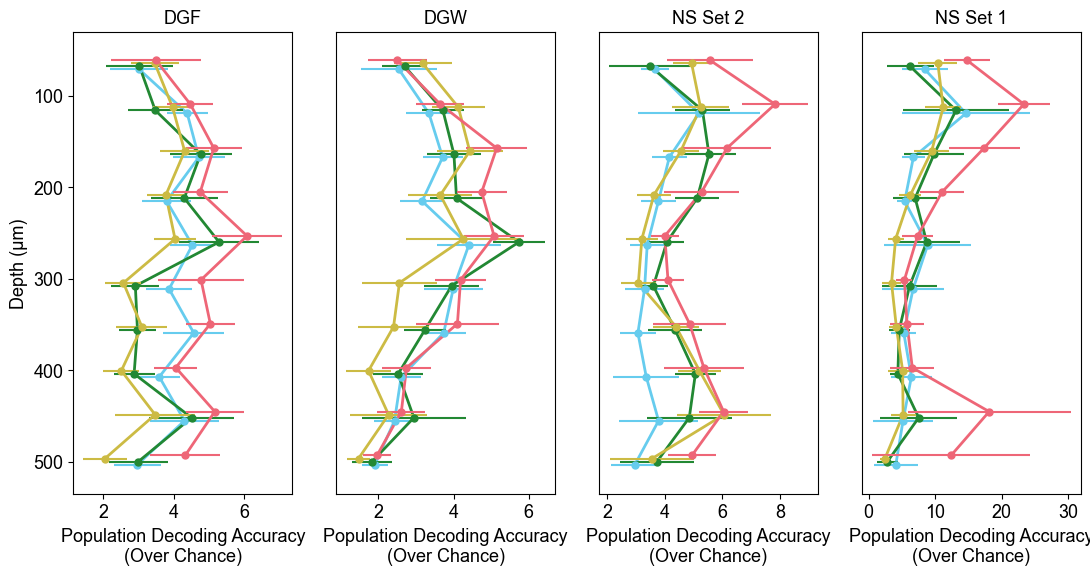

In [ ]:
jitter_amount = 5
num_elements = len(mouse_ids_mod)
jitter_step = jitter_amount * 2 / (num_elements - 1)
jitter_values = np.linspace(-jitter_amount, jitter_amount, num_elements)
fixed_jitters = np.tile(jitter_values, (n_depths, 1))
titles = [
    'DGF',
    'DGW',
    'NS Set 2',
    'NS Set 1'
]

fig = plt.figure(figsize=(13, 6))
for s in range(n_stim_types):
    ax = plt.subplot(1, n_stim_types, s + 1)
    
    for m, mouse_id in enumerate(mouse_ids_mod):
        means = []
        std_errors = []
        mouse_color = mouse_colors[mice[m]]
        
        for z in range(n_depths):
            bootstrapped_values = bootstrapped_data[s, :, z, m, :]
            mean = np.mean(bootstrapped_values)
            std = np.std(bootstrapped_values)
            
            means.append(mean)
            std_errors.append(std)

        jitter = fixed_jitters[:, 3-m]
        y_positions = np.array([int(np.mean(x)) for x in z_groups_low_to_high[:-3]]) + jitter
        
        plt.errorbar(means, y_positions, xerr=std_errors, fmt='o', color=mouse_color, ecolor=mouse_color, capsize=0, markersize=5)
        plt.plot(means, y_positions, color=mouse_color, linewidth=2)

        plt.xlabel('Population Decoding Accuracy\n(Over Chance)', fontsize=fontsize)
        plt.title(titles[s], fontsize=fontsize)
    
    if s == 0:
        plt.yticks(fontsize=fontsize)
        plt.ylabel("Depth (µm)", fontsize=fontsize)
    else:
        plt.yticks([])

    plt.xticks(fontsize=fontsize)
    plt.ylim(30, 535)
    plt.gca().invert_yaxis()
# plt.show()
plt.savefig(os.path.join(figures_dir, '5C_decoding_accuracy_jittered.svg'), format='svg', bbox_inches='tight', dpi=300)

In [ ]:
jitter.shape

(10,)